In [1]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import random
import scanpy as sc
from copy import copy
from tqdm import tqdm
np.random.seed(seed=12345)

In [4]:
adata = sc.read_h5ad("/Users/guojuanru/Desktop/Petti/dataserver/allen_cortex.h5ad")
X_norm = sc.pp.normalize_total(adata, target_sum=1e6, inplace=False)
X_norm['X']

<14249x34617 sparse matrix of type '<class 'numpy.float64'>'
	with 124973672 stored elements in Compressed Sparse Row format>

In [7]:
#make sure how many time of scdata you whant to use (expand your scdata)
adata = adata.concatenate(adata, adata)
adata

AnnData object with n_obs × n_vars = 42747 × 34617
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'sample_type', 'organism', 'donor', 'sex', 'age_days', 'eye_condition', 'genotype', 'driver_lines', 'reporter_lines', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'injection_label_direction', 'injection_primary', 'injection_secondary', 'injection_tract', 'injection_material', 'injection_exclusion_criterion', 'facs_date', 'facs_container', 'facs_sort_criteria', 'rna_amplification_set', 'library_prep_set', 'library_prep_avg_size_bp', 'seq_name', 'seq_tube', 'seq_batch', 'total_reads', 'percent_exon_reads', 'percent_intron_reads', 'percent_intergenic_reads', 'percent_rrna_reads', 'percent_mt_exon_reads', 'percent_reads_unique', 'percent_synth_reads', 'percent_ecoli_reads', 'percent_aligned_reads_total', 'complexity_cg', 'genes_detected_cpm_criterion', 'genes_detected_fpkm_criterion', 'tdt_cpm', 'gfp_cpm', 'class', 'subclass', 'cluster', 'confusion_score', 'cluster

In [8]:
#normalize the data
X_norm = sc.pp.normalize_total(adata, target_sum=1e6, inplace=False)
X_norm['X']

<42747x34617 sparse matrix of type '<class 'numpy.float32'>'
	with 374921016 stored elements in Compressed Sparse Row format>

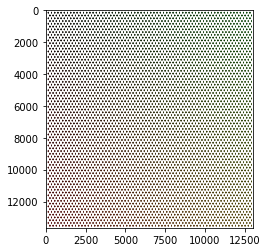

In [10]:
# draw spots
rate = 2
height1 = 6500 * rate
height2 = 6825 * rate

radius = 27.5 * rate
betweencenter = 100 * rate
betweenrow = 50*np.sqrt(3) * rate
temp = np.zeros((height2, height1, 3), np.uint8)
temp[:, :] = [255]

itotal = 78
jtotal = 64
for i in range(78):
    for j in range(64):
        temp = cv2.circle(temp,( int(betweencenter *(j+1+0.5*(i%2))-radius), int(betweenrow *(i+1)) )
                          , int(radius), (i,j,0), -1)
        
plt.imshow(temp)
cv2.imwrite('temp.png', temp) 

def ijtonumber(x,y,ytotal):
    return x*ytotal+y

def numbertoij(total,ytotal):
    return (total//ytotal,total%ytotal)

True

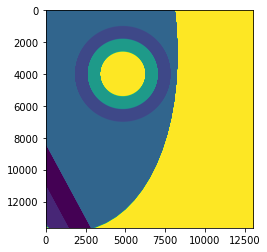

In [11]:
# Creating the photo indecating different areas of cells
# Create anything you like
area = np.zeros((height2, height1, 1), np.uint8)
area[:, :] = [255]

cv2.ellipse(area, (0,0), (7000*rate,4000*rate), 80,  0, 360, 100, -1)
cv2.line(area, (5000*rate,15000*rate), (-2000*rate,2000*rate), 50, 900*rate)
cv2.line(area, (6000*rate,16000*rate), (-1000*rate,3000*rate), 25, 600*rate)
cv2.circle(area, (2400*rate,2000*rate), 1500*rate, 75, -1)
cv2.circle(area, (2400*rate,2000*rate), 1100*rate, 150, -1)
cv2.circle(area, (2400*rate,2000*rate), 700*rate, 255, -1)

plt.imshow(area)
cv2.imwrite('shape.png', area)

In [12]:
# Let's see how are the classes going
classFreq = adata.obs["subclass"].value_counts()
classFreq

L6 IT         5616
Sst           5223
Vip           5184
L4            4203
Pvalb         4011
Lamp5         3366
L2/3 IT       2946
L6 CT         2880
L5 IT         2640
L5 PT         1632
Astro         1104
NP            1086
L6b           1074
Sncg           375
Endo           282
Oligo          273
VLMC           201
SMC            165
Macrophage     153
Meis2          135
Peri            96
Serpinf1        81
CR              21
Name: subclass, dtype: int64

In [13]:
index = adata.obs["subclass"].value_counts().index
index

Index(['L6 IT', 'Sst', 'Vip', 'L4', 'Pvalb', 'Lamp5', 'L2/3 IT', 'L6 CT',
       'L5 IT', 'L5 PT', 'Astro', 'NP', 'L6b', 'Sncg', 'Endo', 'Oligo', 'VLMC',
       'SMC', 'Macrophage', 'Meis2', 'Peri', 'Serpinf1', 'CR'],
      dtype='object')

In [14]:
selectedArea1 = np.asarray(np.where((area == [25]))[0:2]).T
for i in [75,50,100,150]:
    selectedArea1 = np.concatenate((selectedArea1, np.asarray(np.where((area == [i]))[0:2]).T), axis=0)
print(selectedArea1.shape)

selectedArea2 = np.asarray(np.where((area == [150]))[0:2]).T
print(selectedArea2.shape)

selectedArea3 = np.asarray(np.where((area == [75]))[0:2]).T
print(selectedArea3.shape)

selectedArea4 = np.asarray(np.where((area == [25]))[0:2]).T
print(selectedArea4.shape)

selectedArea5 = np.asarray(np.where((area == [50]))[0:2]).T
print(selectedArea5.shape)

(92476070, 2)
(9047720, 2)
(13069000, 2)
(5367916, 2)
(1890624, 2)


In [15]:
#in area1 there are 'L6 IT', 'L4', 'L2/3 IT', 'L6 CT', 'L5 IT', 'L5 PT','L6b', 'Sst','Vip', 'Pvalb'
selectedtypesArea1 = np.concatenate((np.where(adata.obs["subclass"]=="L6 IT")[0],
                                    np.where(adata.obs["subclass"]=="L4")[0],
                                    np.where(adata.obs["subclass"]=="L2/3 IT")[0],
                                    np.where(adata.obs["subclass"]=="L6 CT")[0],
                                    np.where(adata.obs["subclass"]=="L5 IT")[0],
                                    np.where(adata.obs["subclass"]=="L5 PT")[0],
                                    np.where(adata.obs["subclass"]=="L6b")[0],
                                    np.where(adata.obs["subclass"]=="Sst")[0],
                                    np.where(adata.obs["subclass"]=="Vip")[0],
                                    np.where(adata.obs["subclass"]=="Pvalb")[0]))
print(selectedtypesArea1.shape)

#in area2 there are ’NP'
selectedtypesArea2 = (np.where(adata.obs["subclass"]=="NP")[0])
print(selectedtypesArea2.shape)

#in area3 there are  'Vip'
selectedtypesArea3 = (np.where(adata.obs["subclass"]=="Lamp5")[0])
print(selectedtypesArea3.shape)


#in area4 there are   'Astro','NP', ’Endo'
selectedtypesArea4 = np.concatenate((np.where(adata.obs["subclass"]=="Astro")[0],
                                     np.where(adata.obs["subclass"]=="Endo")[0]))
print(selectedtypesArea4.shape)


#in area5 there are  'Sncg','Oligo', 'VLMC', 'SMC', 'Macrophage', 'Meis2', 'Peri', 'Serpinf1', 'CR'
selectedtypesArea5 = np.concatenate((np.where(adata.obs["subclass"]=="Sncg")[0],
                                    np.where(adata.obs["subclass"]=="Oligo")[0],
                                    np.where(adata.obs["subclass"]=="VLMC")[0],
                                    np.where(adata.obs["subclass"]=="SMC")[0],
                                    np.where(adata.obs["subclass"]=="Macrophage")[0],
                                    np.where(adata.obs["subclass"]=="Meis2")[0],
                                    np.where(adata.obs["subclass"]=="Peri")[0],
                                    np.where(adata.obs["subclass"]=="Serpinf1")[0],
                                    np.where(adata.obs["subclass"]=="CR")[0]))
print(selectedtypesArea5.shape)

print(selectedtypesArea1.shape[0]+selectedtypesArea2.shape[0]+selectedtypesArea3.shape[0]
      +selectedtypesArea4.shape[0]+selectedtypesArea5.shape[0] == adata.X.shape[0])

(35409,)
(1086,)
(3366,)
(1386,)
(1500,)
True


In [16]:
selected1 = selectedArea1[random.sample(range(selectedArea1.shape[0]),selectedtypesArea1.shape[0])]
selected2 = selectedArea2[random.sample(range(selectedArea2.shape[0]),selectedtypesArea2.shape[0])]
selected3 = selectedArea3[random.sample(range(selectedArea3.shape[0]),selectedtypesArea3.shape[0])]
selected4 = selectedArea4[random.sample(range(selectedArea4.shape[0]),selectedtypesArea4.shape[0])]
selected5 = selectedArea5[random.sample(range(selectedArea5.shape[0]),selectedtypesArea5.shape[0])]
selected = np.concatenate((selected1,selected2,selected3,selected4,selected5))

selected.shape, np.unique(selected, axis=0).shape

((42747, 2), (42746, 2))

In [17]:
# construct the record metadata array y0+x0+a+b+r+c+total+engaged+i+j;
# (x-x0)^2/a^2 + (y-y0)^2/b^2 = 1
# r equals to the rotation angle
# c equals color
# total means the total pixels of a cell => calculated later
# engaged means the total pixels of a cell in a spot => calculated later
# i,j points to which spot it is in
record = np.zeros([adata.n_obs,2+2+1+1+4], dtype=int)

In [18]:
record[selectedtypesArea1,0:2] = selected1
record[selectedtypesArea2,0:2] = selected2
record[selectedtypesArea3,0:2] = selected3
record[selectedtypesArea4,0:2] = selected4
record[selectedtypesArea5,0:2] = selected5

In [19]:
np.unique(record, axis=0).shape

(42746, 10)

In [20]:
# generated the cell size of each cell randomly.
# You can write codes yourself here to generate the cell cize according to adata.obs["subclass"]
record[:,2:4] = np.random.randint(low = 1*rate, high = 10*rate , size=record[:,2:4].shape)
# generated the rotation angle of each cell randomly (0-90).
record[:,4] = np.random.randint(low = 0, high = 90, size=record[:,4].shape)
# Initialize the spot number it is in. (If it is still 255 255, it means that the cell is not in any spots because 
# there is obviously no spot 255 255)
record[:,8:10] = [255,255]

In [21]:
#initial
totalType = len(index.tolist())
for types in range(totalType):
    record[np.where(adata.obs["subclass"]==index.tolist()[types]),5] = np.full(
        record[np.where(adata.obs["subclass"]==index.tolist()[types])][:,5].shape, 
        np.floor((types*255)/totalType))
record
record[0:10]

array([[ 2396,  2307,     4,     7,    50,    22,     0,     0,   255,
          255],
       [ 5598,  3024,     3,     6,    61,    55,     0,     0,   255,
          255],
       [ 1329,  5001,    11,     7,    58,    55,     0,     0,   255,
          255],
       [10220,  3984,     4,     3,    45,    22,     0,     0,   255,
          255],
       [ 6184,  3733,    19,    16,    65,    55,     0,     0,   255,
          255],
       [13046,  2914,    11,    18,     7,    11,     0,     0,   255,
          255],
       [12581,   599,    11,    13,    46,   144,     0,     0,   255,
          255],
       [ 2742,  2362,    15,    12,    43,    55,     0,     0,   255,
          255],
       [ 5939,   791,    19,     8,    60,    22,     0,     0,   255,
          255],
       [ 2747,  2719,     9,    13,    68,    55,     0,     0,   255,
          255]])

In [24]:
# start recording
image = np.zeros((height2, height1, 1), np.uint8)
image[:, :] = [255]
blank = np.zeros((height2, height1, 1), np.uint8)
blank[:, :] = [0]
thickness = -1

for cells in tqdm(range(1,adata.X.shape[0])):
    blankdraw = copy(blank)
    cv2.ellipse(image, (record[cells][1],record[cells][0]), 
                (record[cells][2],record[cells][3]), record[cells][4], 
                0, 360, int(record[cells][5]), thickness)
    cv2.ellipse(blankdraw, (record[cells][1],record[cells][0]), 
                (record[cells][2],record[cells][3]), record[cells][4], 
                0, 360, 1, thickness)
    
    record[cells][6] = np.sum(blankdraw)
    rows1, cols1, channels1 = np.where((blank-blankdraw) != 0)
    freq = np.unique(temp[rows1, cols1][:,0:2],axis =0,return_counts=True)
    record[cells][7] = freq[1][0]
    record[cells][8:10] = freq[0][0]

100%|██████████| 42746/42746 [12:00:40<00:00,  1.01s/it]   


True

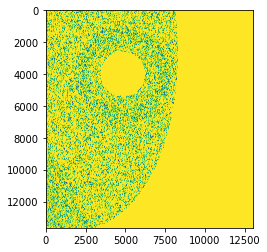

In [25]:
plt.imshow(image)
cv2.imwrite('image.png', image) 

In [26]:
#calculate the gene expression of each spot (use the normalized scdata). 
# [sum(engaged/total * geneexpressionOfEachCell)] * randomNormal
spots = np.zeros((itotal*jtotal, X_norm['X'].shape[1]))

for i in range(itotal):
    for j in range(jtotal):
        weight = record[(record[:,8] == i)* (record[:,9] == j),:][:,7]/record[(record[:,8] == i)* (record[:,9] == j),:][:,6]
        weight = weight.reshape(1,weight.shape[0])
        spots[ijtonumber(i,j,jtotal),:] = weight*X_norm['X'][(record[:,8] == i)* (record[:,9] == j),:]*np.min(np.random.normal(1, 0.05, 1))
        

In [27]:
spots.shape

(4992, 34617)

In [28]:
finalspot_norm = spots[~np.all(spots == 0, axis=1)]
finalspot_norm.shape

(2628, 34617)

In [29]:
finalimage = copy(image)

True

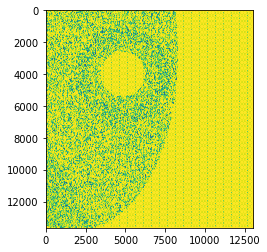

In [30]:
#draw the final picture
finalimage = copy(image)
for i in range(itotal):
    for j in range(jtotal):
        finalimage = cv2.circle(finalimage,(int(betweencenter *(j+1+0.5*(i%2))-radius), int(betweenrow *(i+1)) )
                          , int(radius), 0, 2)    
        
plt.imshow(finalimage)
cv2.imwrite('finalimage.png', finalimage) 


<AxesSubplot:>

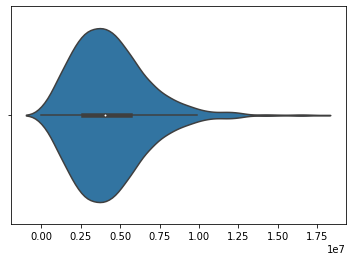

In [31]:
import seaborn as sns 
sns.violinplot(x=np.sum(finalspot_norm,axis = 1))

In [32]:
#calculate the gene expression of each spot (use the unnormalized scdata). 
# [sum(engaged/total * geneexpressionOfEachCell)] * randomNormal

import pandas as pd
spot = np.zeros((itotal*jtotal, X_norm['X'].shape[1]))
spotrecord = pd.DataFrame(np.zeros((itotal*jtotal, index.shape[0])),columns= index)


for i in range(itotal):
    for j in range(jtotal):
        weight = record[(record[:,8] == i)* (record[:,9] == j),:][:,7]/record[(record[:,8] == i)* (record[:,9] == j),:][:,6]
        weight = weight.reshape(1,weight.shape[0])
        spot[ijtonumber(i,j,jtotal),:] = weight*adata.X[(record[:,8] == i)* (record[:,9] == j),:]*np.min(np.random.normal(1, 0.05, 1))

        names = np.array(adata.obs["subclass"])[(record[:,8] == i)* (record[:,9] == j)]
        for cells in range(names.shape[0]):
            spotrecord[names[cells]][ijtonumber(i,j,jtotal)] += weight[0][cells]
            
spot = np.round(spot).astype(int)
        

In [33]:
spot.shape

(4992, 34617)

In [34]:
finalspots = spot[~np.all(spots == 0, axis=1)]
finalcompo = spotrecord[~np.all(spots == 0, axis=1)]

finalspots.shape

(2628, 34617)

<AxesSubplot:>

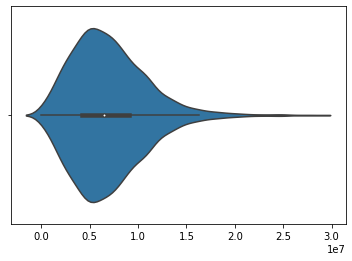

In [35]:
sns.violinplot(x=np.sum(finalspots,axis = 1))

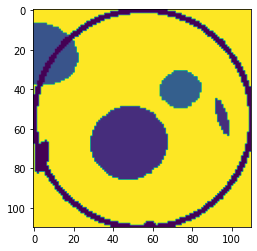

In [36]:
#Let's see one spot more clearly

i = 45
j = 10
plt.imshow(finalimage[int(betweenrow *(i+1))-int(radius):int(betweenrow *(i+1)) +int(radius),
                     int(betweencenter *(j+1+0.5*(i%2))-radius)-int(radius):int(betweencenter *(j+1+0.5*(i%2))-radius)+int(radius)])

True

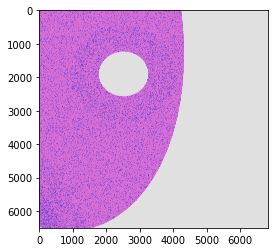

In [37]:
# Change the color
images = np.zeros((height2, height1, 3), np.uint8)
images[:, :, :] = [224]
rows, cols, channels = np.where(area!= 255)
images[rows, cols,0] = 218*np.ones_like(images[rows, cols,0], np.uint8)
images[rows, cols,1] = 112*np.ones_like(images[rows, cols,1], np.uint8)
images[rows, cols,2] = 214*np.ones_like(images[rows, cols,2], np.uint8)
rows, cols, channels = np.where(image!= 255)
images[rows, cols,0] = 93*np.ones_like(images[rows, cols,0], np.uint8)
images[rows, cols,1] = 63*np.ones_like(images[rows, cols,1], np.uint8)
images[rows, cols,2] = 211*np.ones_like(images[rows, cols,2], np.uint8)
images = cv2.resize(images, (int(height2/rate),int( height1/rate)))
plt.imshow(images)
cv2.imwrite('images.png', cv2.cvtColor(images, cv2.COLOR_RGB2BGR)) 

True

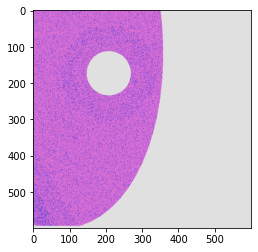

In [38]:
#Adapt to the size of seurat object
tissue_lowres_image = np.zeros((599, 600, 3), np.uint8)
tissue_lowres_image[:, :, :] = [224]
tissue_lowres_image[0:int(height2/23), 0:int(height1/23), :] = cv2.resize(images, (int(height1/23), int(height2/23)))

plt.imshow(tissue_lowres_image)
cv2.imwrite('tissue_lowres_image.png', cv2.cvtColor(tissue_lowres_image, cv2.COLOR_RGB2BGR)) 

In [39]:
# save the position information for seurat object
position = np.zeros((itotal*jtotal, 4))
itotal = 78
jtotal = 64
for i in range(78):
    for j in range(64):
        position[ijtonumber(i,j,jtotal),:] = [i+1,2*j+i%2+1,int(betweenrow *(i+1)),
                                              int(betweencenter *(j+1+0.5*(i%2))-radius)]

position = position[~np.all(spots == 0, axis=1)]
np.savetxt("position.csv", position, delimiter=",")

In [40]:
# save the data for seurat object
import anndata
from scipy.sparse import csr_matrix
data = csr_matrix(finalspots)
data = sc.AnnData(data)
data.var = adata.var
data.obs = pd.DataFrame({'nCount_Spatial':finalspots.sum(axis = 1), 'nFeature_Spatial':(finalspots>0).sum(axis = 1)})
data.obs.index += 1 
data.write("spot_allen_cortex.h5ad")

In [41]:
data

AnnData object with n_obs × n_vars = 2628 × 34617
    obs: 'nCount_Spatial', 'nFeature_Spatial'
    var: 'features'

In [43]:
#save ground truth data
finalcompo.to_csv("truth.csv")